# CS375 - Assignment 3: LN model

In this notebook, we show the training and validation results of training the LN model on natural scene and white noise data.

In [1]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

### Getting data from the database
Let's connect to the database and pull the data training and test data that is stored while training our network.
In order to find the right experiment id, it is useful to display which experiments are stored in the database first.

In [2]:
# connect to database
dbname = 'ln_model'
wn = 'whitenoise'
ns = 'naturalscene'
exp_id = 'trainval0'
port = 24444

conn = pm.MongoClient(port = port)
c_wn = conn[dbname][wn + '.files']
c_ns = conn[dbname][ns + '.files']

# print out saved experiments in collection coll
print(c_wn.distinct('exp_id'))
print(c_ns.distinct('exp_id'))

[u'trainval0', u'testval0', u'testval_step50', u'testval_step100', u'testval_step150', u'testval_step200', u'testval_step250', u'testval_step300', u'testval_step350', u'testval_step400', u'testval_step450', u'testval_step500', u'testval_step550', u'testval_step600', u'testval_step650', u'testval_step700', u'testval_step750', u'testval_step800', u'testval_step850', u'testval_step900', u'testval_step950', u'testval_step1000', u'testval_step1050', u'testval_step1100', u'testval_step1150', u'testval_step1200', u'testval_step1250', u'testval_step1300', u'testval_step1350', u'testval_step1400', u'testval_step1450', u'testval_step1500', u'testval_step1550', u'testval_step1600', u'testval_step1650', u'testval_step1700', u'testval_step1750', u'testval_step1800', u'testval_step1850', u'testval_step1900', u'testval_step1950', u'testval_step2000', u'testval_step2050', u'testval_step2100', u'testval_step2150', u'testval_step2200', u'testval_step2250', u'testval_step2300', u'testval_step2350', u'tes

### Plotting the training curve

In [3]:
from scipy.signal import convolve

def smooth_signal(lst, smooth=5):
    return convolve(lst, np.ones((smooth))/smooth, 'valid')

def get_losses(coll, exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

def get_steps(coll, exp_id):
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    steps = [i['step'] for i in coll.find(q_train)]
    return steps

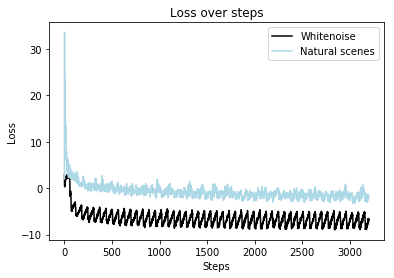

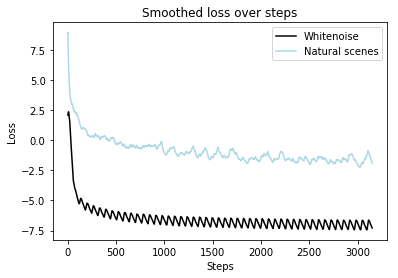

In [9]:
loss_wn = get_losses(c_wn, exp_id)
loss_ns = get_losses(c_ns, exp_id)

# Plot the training loss

plt.figure()
plt.title('Loss over steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(loss_wn,label='Whitenoise',color='black')
plt.plot(loss_ns,label='Natural scenes',color='lightblue')
plt.legend()

smooth_wn = smooth_signal(loss_wn, smooth=50)
smooth_ns = smooth_signal(loss_ns, smooth=50)
plt.figure()
plt.title('Smoothed loss over steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(smooth_wn,label='Whitenoise',color='black')
plt.plot(smooth_ns,label='Natural scenes',color='lightblue')
plt.legend()

From these plots, we see that the LN model more easily fits the white noise than natural scenes, as shown by the noticeably lower loss. However, the LN model also converges at about the same rate for both stimulus types, largely bottoming out after around 1000 steps.

### Poisson loss

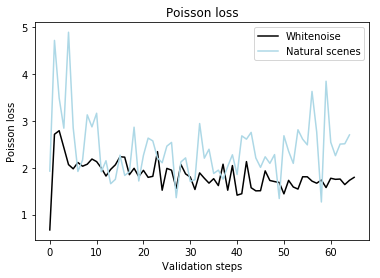

In [13]:
def get_validation_data(coll,exp_id, key1='topn_val', key2='loss'):
    """
    Gets the validation data from the database (except for gridfs data)
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    return [val_steps[i]['validation_results'][key1][key2]
            for i in range(val_steps.count())]


### PLOT VALIDATION RESULTS HERE
# losses = get_validation_data('mc_colorize')
losses = get_validation_data(c_wn,exp_id, 'test_loss', 'poisson_loss')
wn_min_index = np.argmin(losses[1:])
plt.plot(losses,label='Whitenoise',color='black')
losses = get_validation_data(c_ns,exp_id, 'test_loss', 'poisson_loss')
ns_min_index = np.argmin(losses[1:])
plt.plot(losses,label='Natural scenes',color='lightblue')
plt.title('Poisson loss')
plt.legend()
plt.xlabel('Validation steps')
plt.ylabel('Poisson loss')

The validation loss curves show evidence of overfitting, particularly on the natural scenes dataset, as validation loss begins to increase near the end of the training curve.

# Validation (Pearson Correlation)

In [6]:
def get_correlation_val(coll):
    # get validation data
    val_results = {}
    steps = get_steps(coll, 'trainval0')
    pearson_results = {}
    for step in steps:
        val_results[step] = {}
        val_exp_id = 'testval_step%s' % step    
        val_result = list(coll.find({'exp_id' : val_exp_id, 
                                    'validation_results' : {'$exists' : True}}, 
                                       projection=['validation_results']))
        val_results[step]['naturalscene'] = np.mean(val_result[-1]['validation_results']['naturalscene_pearson'].values())
        val_results[step]['whitenoise'] = np.mean(val_result[-1]['validation_results']['whitenoise_pearson'].values())
    return val_results

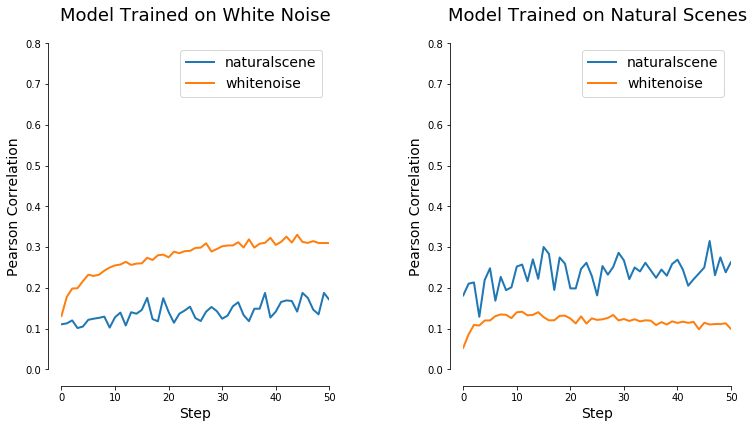

In [15]:
wn_val = get_correlation_val(c_wn)
ns_val = get_correlation_val(c_ns)

f, axes = plt.subplots(1, 2, figsize=(12,6))
ax1, ax2 = axes
ax1.plot([wn_val[s]['naturalscene'] for s in sorted(wn_val.keys())], linewidth=2, label='naturalscene')
ax1.plot([wn_val[s]['whitenoise'] for s in sorted(wn_val.keys())], linewidth=2,  label='whitenoise')
ax1.set_title('Model Trained on White Noise', fontsize=18, y=1.05)

ax2.plot([ns_val[s]['naturalscene'] for s in sorted(ns_val.keys())], linewidth=2,  label='naturalscene')
ax2.plot([ns_val[s]['whitenoise'] for s in sorted(ns_val.keys())], linewidth=2,  label='whitenoise')
ax2.set_title('Model Trained on Natural Scenes', fontsize=18, y=1.05)


for ax in [ax1, ax2]:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    ax.legend(fontsize=14)
    ax.set_ylim(0,.8)
    ax.set_xlim(0,50)
    ax.set_xlabel('Step', fontsize=14)
    ax.set_ylabel('Pearson Correlation', fontsize=14)
    
plt.subplots_adjust(wspace=.5)

As expected, the correlation coefficient is higher when the input stimulus type and the training stimulus type are the same. In addition, the correlation coefficients of the CNN validation results dominate those of the LN results for all four training-validation stimulus combinations.